                                      IMPORTING NECESSARY PACKAGES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import warnings
warnings.filterwarnings('ignore')
import random
random.seed(42)
# dataset link : https://www.kaggle.com/datasets/atharvaingle/crop-recommendation-dataset?resource=download



                                    EXPLORATORY DATA ANALYSIS

In [2]:
# read crop dataset
data = pd.read_csv("dataset\Crop_recommendation.csv")
print(data.head())
# classes
classes = data['label'].unique()
print("\ncrop types : ",classes)

    N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice

crop types :  ['rice' 'maize' 'chickpea' 'kidneybeans' 'pigeonpeas' 'mothbeans'
 'mungbean' 'blackgram' 'lentil' 'pomegranate' 'banana' 'mango' 'grapes'
 'watermelon' 'muskmelon' 'apple' 'orange' 'papaya' 'coconut' 'cotton'
 'jute' 'coffee']


In [3]:
# check for missing values

data.isna().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

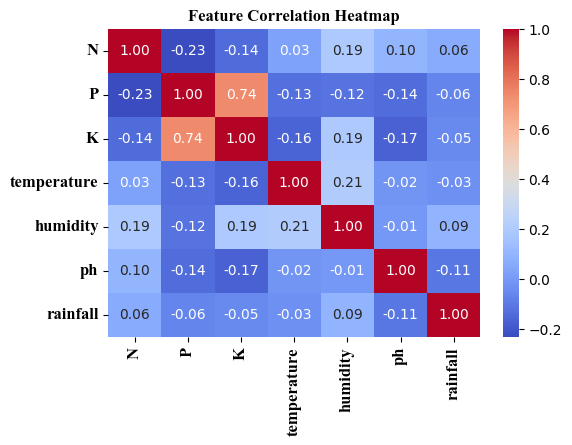

In [4]:

# Plot correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(data.drop('label',axis=1).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.xticks(rotation=90,fontname='Times New Roman',fontsize=12,fontweight='bold')
plt.yticks(fontname='Times New Roman',fontsize=12,fontweight='bold')
plt.title("Feature Correlation Heatmap",fontname='Times New Roman',fontsize=12,fontweight='bold')
plt.savefig('Results/heatmap.jpg',dpi=600)
plt.show()

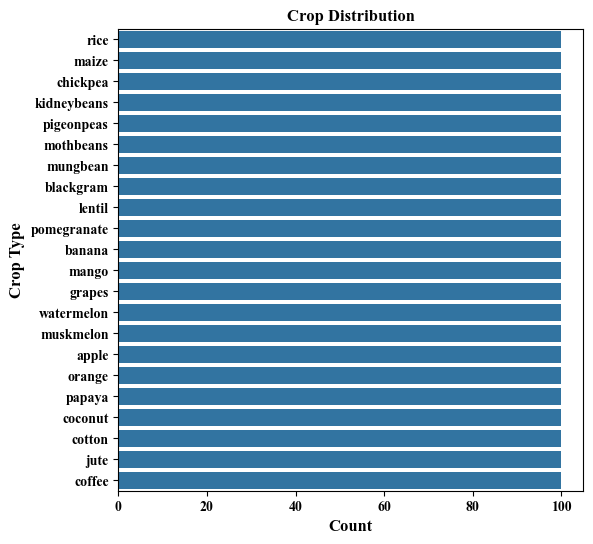

In [5]:
# Countplot for crop distribution
plt.figure(figsize=(6, 6))
sns.countplot(y=data['label'], order=data['label'].value_counts().index)
plt.title("Crop Distribution",fontname='Times New Roman',fontsize=12,fontweight='bold')
plt.xlabel("Count",fontname='Times New Roman',fontsize=12,fontweight='bold')
plt.ylabel("Crop Type",fontname='Times New Roman',fontsize=12,fontweight='bold')
plt.xticks(fontname='Times New Roman',fontsize=10,fontweight='bold')
plt.yticks(fontname='Times New Roman',fontsize=10,fontweight='bold')
plt.savefig('Results/countplot.jpg',dpi=600)
plt.show()


<Figure size 600x600 with 0 Axes>

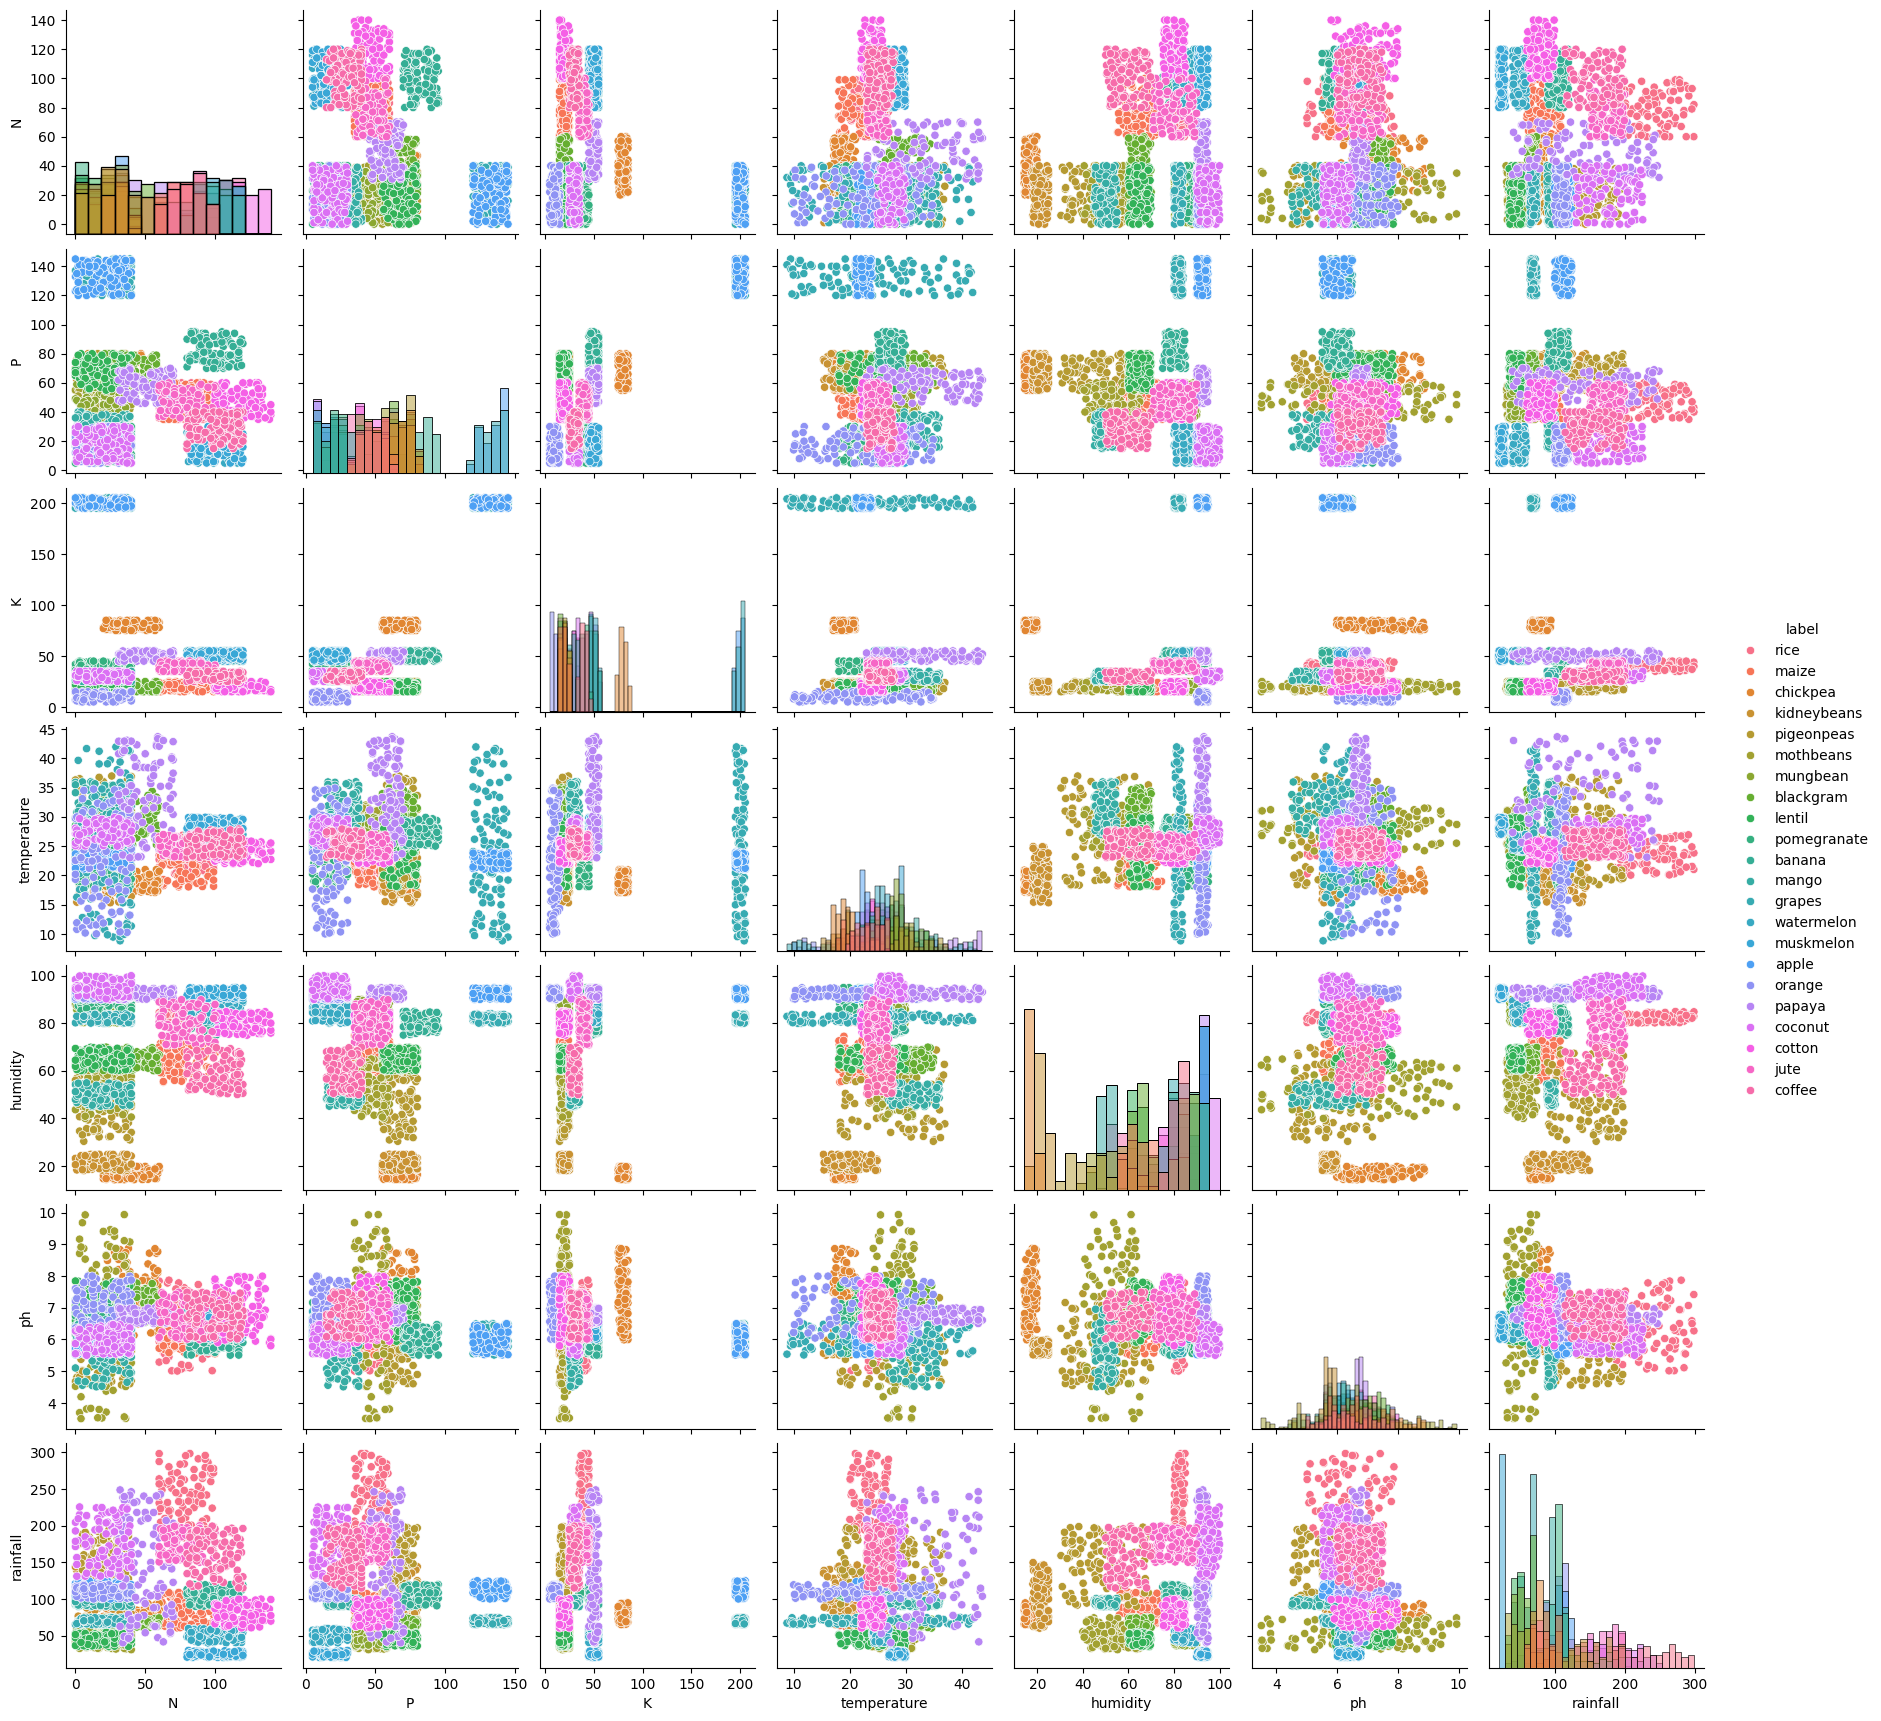

In [6]:
# Pairplot to visualize relationships
plt.figure(figsize=(6, 6))
sns.pairplot(data, hue="label", diag_kind="hist")
plt.xticks(fontname='Times New Roman',fontsize=12,fontweight='bold')
plt.yticks(fontname='Times New Roman',fontsize=12,fontweight='bold')
plt.savefig('Results/pairplot.jpg',dpi=600)
plt.show()

                  DATA PREPROCESSING -  Outlier Removal, Feature Encoding, Feature Scaling

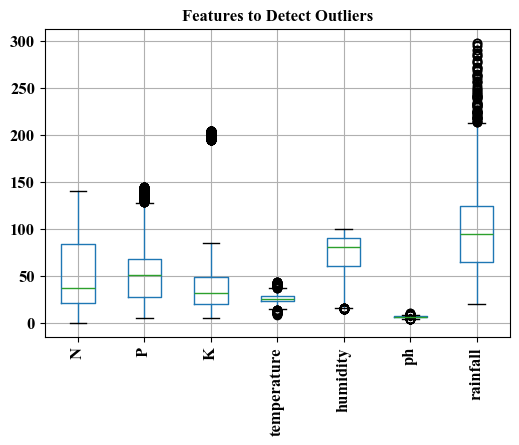

Outliers detected in N: 0
Outliers detected in P: 138
Outliers detected in K: 200
Outliers detected in temperature: 86
Outliers detected in humidity: 30
Outliers detected in ph: 57
Outliers detected in rainfall: 100


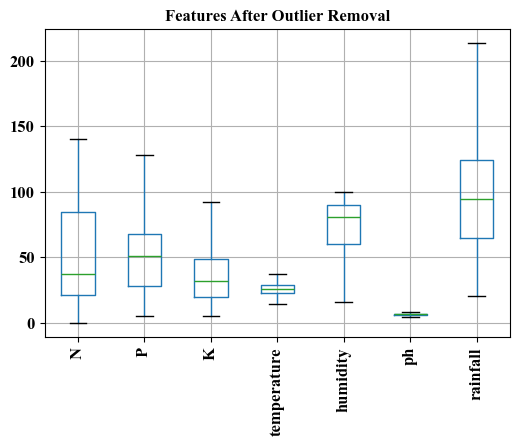

In [7]:
# Boxplot to check outliers
plt.figure(figsize=(6, 4))
data.drop(columns=['label']).boxplot()
plt.xticks(rotation=90)
plt.xticks(fontname='Times New Roman',fontsize=12,fontweight='bold')
plt.yticks(fontname='Times New Roman',fontsize=12,fontweight='bold')
plt.title("Features to Detect Outliers",fontname='Times New Roman',fontsize=12,fontweight='bold')
plt.savefig('Results/outliers.jpg',dpi=600)
plt.show()

def detect_outliers_iqr(data, column):  #Interquartile Range
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

numeric_cols = data.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    outliers = detect_outliers_iqr(data, col)
    print(f"Outliers detected in {col}: {len(outliers)}")

# Handling outliers (Capping the values)
for col in numeric_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])
    data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])

# check outlier after handling outlier removal function
plt.figure(figsize=(6, 4))
data.drop(columns=['label']).boxplot()
plt.xticks(rotation=90)
plt.xticks(fontname='Times New Roman',fontsize=12,fontweight='bold')
plt.yticks(fontname='Times New Roman',fontsize=12,fontweight='bold')
plt.title("Features After Outlier Removal",fontname='Times New Roman',fontsize=12,fontweight='bold')
plt.savefig('Results/afteroutlierremoval.jpg',dpi=600)
plt.show()


In [8]:
# extract target and data

X = data.drop('label',axis=1)
Y = data['label']

In [9]:

# Apply Label Encoding
le = LabelEncoder()
Y = le.fit_transform(Y)

print("Label Mapping:", dict(zip(le.classes_, range(len(le.classes_)))))

# split data for training and trsting , 20 % for testing and 80 % for training
X_train, X_test ,y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=1)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

joblib.dump(scaler, 'Model/scaler.pkl')

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Label Mapping: {'apple': 0, 'banana': 1, 'blackgram': 2, 'chickpea': 3, 'coconut': 4, 'coffee': 5, 'cotton': 6, 'grapes': 7, 'jute': 8, 'kidneybeans': 9, 'lentil': 10, 'maize': 11, 'mango': 12, 'mothbeans': 13, 'mungbean': 14, 'muskmelon': 15, 'orange': 16, 'papaya': 17, 'pigeonpeas': 18, 'pomegranate': 19, 'rice': 20, 'watermelon': 21}
(1760, 7)
(440, 7)
(1760,)
(440,)


                                     MODEL SELECTION & TRAINING

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "Support Vector Machine": SVC(),
    "Naive Bayes": GaussianNB()
}
cnf_mtx = {}
accuracy = {}
trained_model = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracy[name] = acc
    trained_model[name] = model
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    cnf = confusion_matrix(y_test, y_pred)
    cnf_mtx[name] = cnf




Logistic Regression Accuracy: 0.9614
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        18
           2       0.91      0.95      0.93        22
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        18
           5       1.00      1.00      1.00        17
           6       0.96      1.00      0.98        22
           7       1.00      1.00      1.00        29
           8       0.88      0.84      0.86        25
           9       0.95      0.95      0.95        20
          10       0.95      1.00      0.97        18
          11       1.00      0.95      0.97        20
          12       1.00      1.00      1.00        17
          13       1.00      0.96      0.98        24
          14       1.00      1.00      1.00        24
          15       0.96      1.00      0.98        26
          16       1.00      1.00      1.00

                                          MODEL EVALUATION

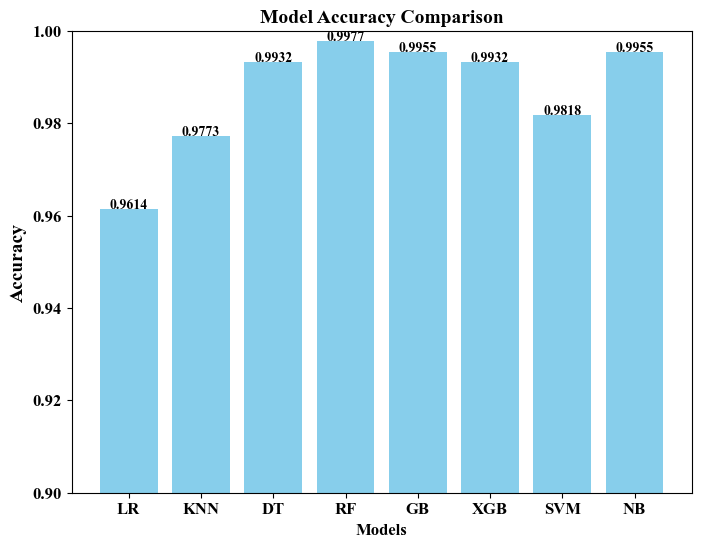


Best Model : Random Forest with Accuracy 0.9977272727272727


['Model/rf_model.pkl']

In [11]:
# selecting best model based on accuracy and save model

model_names = ['LR','KNN','DT','RF','GB','XGB','SVM','NB']
model_scores = list(accuracy.values())
plt.figure(figsize=(8, 6))
plt.bar(model_names, model_scores, color="skyblue")  
plt.xlabel("Models", fontsize=12, fontweight="bold", fontname="Times New Roman")
plt.ylabel("Accuracy", fontsize=14, fontweight="bold", fontname="Times New Roman")
plt.title("Model Accuracy Comparison", fontsize=14, fontweight="bold", fontname="Times New Roman")
plt.xticks(fontname='Times New Roman',fontsize=12,fontweight='bold')
plt.yticks(fontname='Times New Roman',fontsize=12,fontweight='bold')
for index, value in enumerate(model_scores):
    plt.text(index, value + 0.00008, f"{value:.4f}", ha="center", fontsize=10, fontname="Times New Roman",fontweight='bold')
plt.ylim(0.9, 1)  
plt.savefig('Results/accuracy_comp.jpg',dpi=600)
plt.show()


best_model = max(accuracy, key=accuracy.get)
print(f"\nBest Model : {best_model} with Accuracy {accuracy[best_model]}")

model = trained_model[best_model]
joblib.dump(model, 'Model/rf_model.pkl')

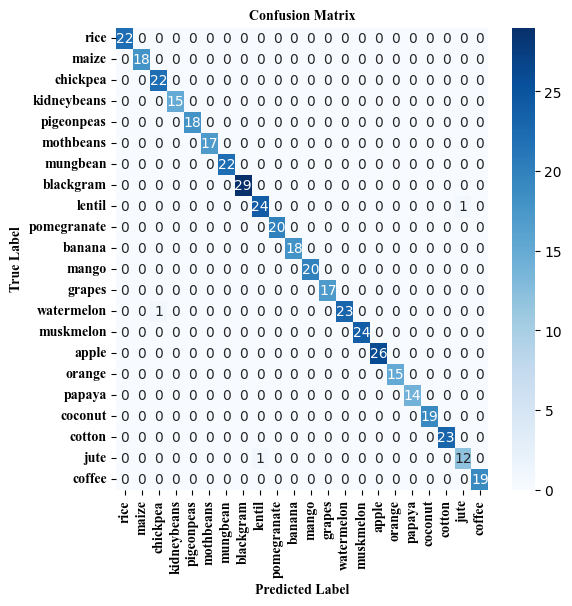

In [12]:
# plot confusion metrix for Random Forest
plt.figure(figsize=(6, 6))
sns.heatmap(cnf_mtx['Decision Tree'], annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label',fontname='Times New Roman',fontsize=10,fontweight='bold')
plt.ylabel('True Label',fontname='Times New Roman',fontsize=10,fontweight='bold')
plt.xticks(fontname='Times New Roman',fontsize=10,fontweight='bold')
plt.yticks(fontname='Times New Roman',fontsize=10,fontweight='bold')
plt.title('Confusion Matrix',fontname='Times New Roman',fontsize=10,fontweight='bold')
plt.savefig('Results/cnf_rf.jpg',dpi=600)
plt.show()


In [13]:

precision = precision_score(y_test, y_pred, average='weighted')  
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')


Precision: 0.9958
Recall: 0.9955
F1-score: 0.9954
